<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/image_augmentation_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Data augmentation for images

We illustrate some simple data augmentation methods form images.
Based on sec 13.1 of http://d2l.ai/chapter_computer-vision/image-augmentation.html

In [5]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(seed=1)
import math

import torch
from torch import nn
from torch.nn import functional as F
import torchvision

!mkdir figures # for saving plots

!wget https://raw.githubusercontent.com/d2l-ai/d2l-en/master/d2l/torch.py -q -O d2l.py
import d2l

mkdir: cannot create directory ‘figures’: File exists


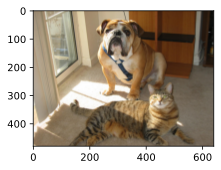

In [2]:
d2l.set_figsize()
#img = d2l.Image.open('../img/cat1.jpg')

#url = 'https://github.com/d2l-ai/d2l-en/blob/master/img/cat1.jpg?raw=true'
url = 'https://github.com/probml/pyprobml/blob/master/images/cat_dog.jpg?raw=true'
fname = 'img.jpg'
!wget $url -q -O $fname


img = d2l.Image.open(fname)

d2l.plt.imshow(img);

In [33]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(img.numpy())
        else:
            # PIL Image
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    plt.tight_layout()
    return fig, axes

To visualize an image augmentation, which may be stochastic, we apply it multiple times to an image.


In [31]:

def apply(img, aug, num_rows=1, num_cols=4, scale=2):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    fig, axes = show_images(Y, num_rows, num_cols, scale=scale)
    return fig, axes

# Flipping

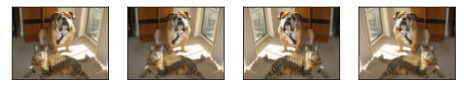

In [8]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

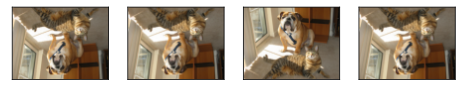

In [9]:
apply(img, torchvision.transforms.RandomVerticalFlip())

# Crop and resize

Below, we randomly crop a region with an area of 10% to 100% of the original area, and the ratio of width to height of the region is randomly selected from between 0.5 and 2. Then, the width and height of the region are both scaled to 200 pixels. 


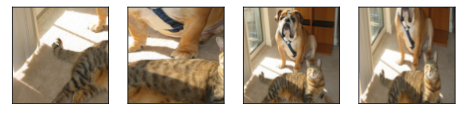

In [10]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

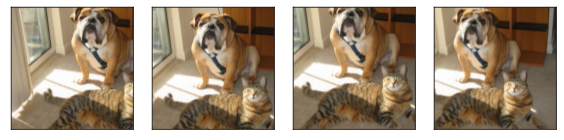

In [35]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.5, 1), ratio=(1, 1))
fig, axes = apply(img, shape_aug)
fig.savefig('dog_cat_augment.png')

# Changing color

We can change brightness, contrast, saturation and hue.
First we change brightness, from 1-0.5=0.5 times less to 1+0.5=1.5 times more.

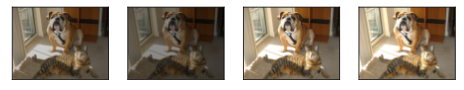

In [11]:
apply(
    img,
    torchvision.transforms.ColorJitter(brightness=0.5, contrast=0,
                                       saturation=0, hue=0))

Now we change hue.

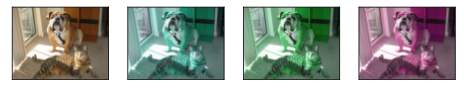

In [12]:
apply(
    img,
    torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0,
                                       hue=0.5))

Now we change saturation.

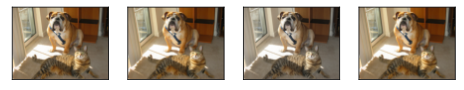

In [13]:
apply(
    img,
    torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0.5,
                                       hue=0))

Now we change contrast.

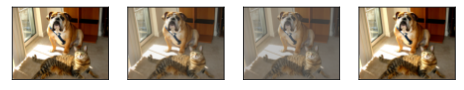

In [14]:
apply(
    img,
    torchvision.transforms.ColorJitter(brightness=0, contrast=0.5, saturation=0,
                                       hue=0))

Now we change all of them.

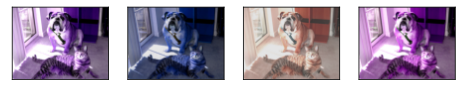

In [15]:
color_aug = torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5,
                                               saturation=0.5, hue=0.5)
apply(img, color_aug)

# Combining multiple augmentations in a pipeline

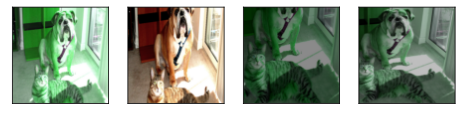

In [16]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

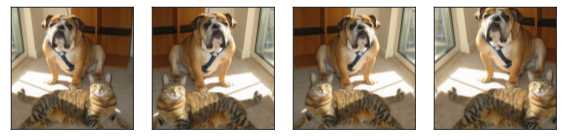

In [39]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), shape_aug])
fig, axes = apply(img, augs)
fig.savefig('dog_cat_augment2.png')

# Using augmentations in a dataloader

We illustrate how we can transform training and test images from CIFAR10.


Extracting ../data/cifar-10-python.tar.gz to ../data


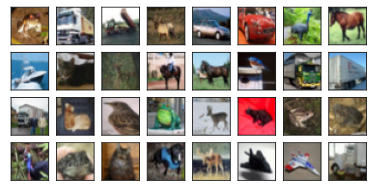

In [17]:
all_images = torchvision.datasets.CIFAR10(train=True, root="../data",
                                          download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

In [18]:
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])

In [19]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train,
                                           transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=is_train,
        num_workers=d2l.get_dataloader_workers())
    return dataloader

In [20]:
train_iter = load_cifar10(True, train_augs, 32)
for i, (features, labels) in enumerate(train_iter):
  print(i)
  print(features.shape)
  if i>=1: break

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0
torch.Size([32, 3, 32, 32])
1
torch.Size([32, 3, 32, 32])
